# Generate a restricted SCvH EOS table for a H-He mixture
Generate a new EOS table based on the SCvH equation of state [Saumon et al. 1995](https://ui.adsabs.harvard.edu/abs/1995ApJS...99..713S/abstract) for Hydrogen and Helium with extensions to lower temperatures [Vazan et al. 2013](https://academic.oup.com/mnras/article/434/4/3283/961935) restricted to low densities and temperatures where the isotherms behave sensible. In this regime the fluid behaves like an ideal gas and the EOS can be extended to $\rho \to 0$ using the ideal gas law.





### Import modules

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import interpolate as interp
#from scipy import optimize
import numpy as np

In [2]:
%matplotlib widget
%config InlineBackend.figure_format = 'retina'

In [3]:
mpl.rcParams['figure.dpi'] = 100

The mixture was obtained using the additive volume law (AVL) and Y=0.275.

In [4]:
data = np.loadtxt("scvh_hhe_y0.275_dt_cgs.csv", delimiter=",", skiprows=1) 

logT_table   = data[:, 0] 
logrho_table = data[:, 1]
logP_table   = data[:, 2]
logu_table   = data[:, 3]
logs_table   = data[:, 4]

# All SCVH EOS tables obtained from Ravit have the same size
nRho = 201
nT   = 100

logrho_table = logrho_table[0:nRho]
logT_table = logT_table[0:np.size(logT_table):nRho]

logrho_min = np.min(logrho_table)
logrho_max = np.max(logrho_table)
logT_min   = np.min(logT_table)
logT_max   = np.max(logT_table)
    
dlogrho = logrho_table[1:]-logrho_table[:-1]
dlogT = logT_table[1:]-logT_table[:-1]

print("logrho_min = {:}".format(logrho_min))
print("logrho_max = {:}".format(logrho_max))
print("logT_min   = {:}".format(logT_min))
print("logT_max   = {:}".format(logT_max))
print()
#print("logrho_table = {:}".format(logrho_table))
#print("logT_table   = {:}".format(logT_table))
#print()

# Mark where the original SCvH EOS table was extended below T=100K
index = np.min(np.where(logT_table>=2.0))
print("The EOS table was extended until index={:} logT={:}".format(index, logT_table[index]))


# Split into arrays of constant T
logP_array = np.split(logP_table, nT)
logu_array = np.split(logu_table, nT)
logs_array = np.split(logs_table, nT)

# Generate 2d arrays
logP = np.vstack(logP_array)
logu = np.vstack(logu_array)
logs = np.vstack(logs_array)


logrho_min = -8.0
logrho_max = 2.0
logT_min   = 1.06
logT_max   = 6.01

The EOS table was extended until index=19 logT=2.01


In [5]:
# Write an EOS table to an output file.
def write_eos_table(filename, logrho_axis, logT_axis, logP_array, logu_array, logs_array, delimiter=",", comments="#"):
    nRho = np.size(logrho_axis)
    nT = np.size(logT_axis)
    
    # Store the different isotherms in 1d arrays
    logrho = np.tile(logrho_axis, nT)
    logT = np.repeat(logT_axis, nRho)

    logP = logP_array.flatten(order='C')
    logu = logu_array.flatten(order='C')
    logs = logs_array.flatten(order='C')
    
    header = "nT = {:} nRho= {:}\n"\
             "{:},{:},{:},{:},{:}".format(nT, nRho, "logT [K]", "logRho [g/cc]", "logP [barye]", "logE [erg/g]", "logS [erg/g/K]")
    
    np.savetxt(filename, np.column_stack([logT, logrho, logP, logu, logs]), header=header, fmt='%.8f', delimiter=delimiter, comments=comments)
    

In [6]:
# Test if write_eos_table works
write_eos_table("output.txt", logrho_table, logT_table, logP, logu, logs)

In [7]:
def press_ideal_gas(rho, T, mu=2.3, gamma=5.0/3.0):
    kB = 1.38e-16  # erg/K
    m_H = 1.67e-24 # g
    return kB/(mu*m_H)*rho*T

In [8]:
def intenergy_ideal_gas(T, mu=2.3, gamma=5.0/3.0):
    kB = 1.38e-16  # erg/K
    m_H = 1.67e-24 # g
    return kB/((gamma-1.0)*mu*m_H)*T

In [9]:
def entropy_ideal_gas(T, mu=2.3, gamma=5.0/3.0):
    kB = 1.38e-16  # erg/K
    m_H = 1.67e-24 # g
    return kB/(mu*m_H)*(np.log(T/T0) - 1.0/(gamma-1.0)*np.log(rho/rho0))

In [10]:
# Skip some curves otherwise the plots are very hard to read
nSkipT = 4
nSkipRho = 8

[Text(0.5, 0, 'log(T) [K]'), Text(0, 0.5, 'log(s) [erg g$^{-1}$ K$^{-1}$]')]

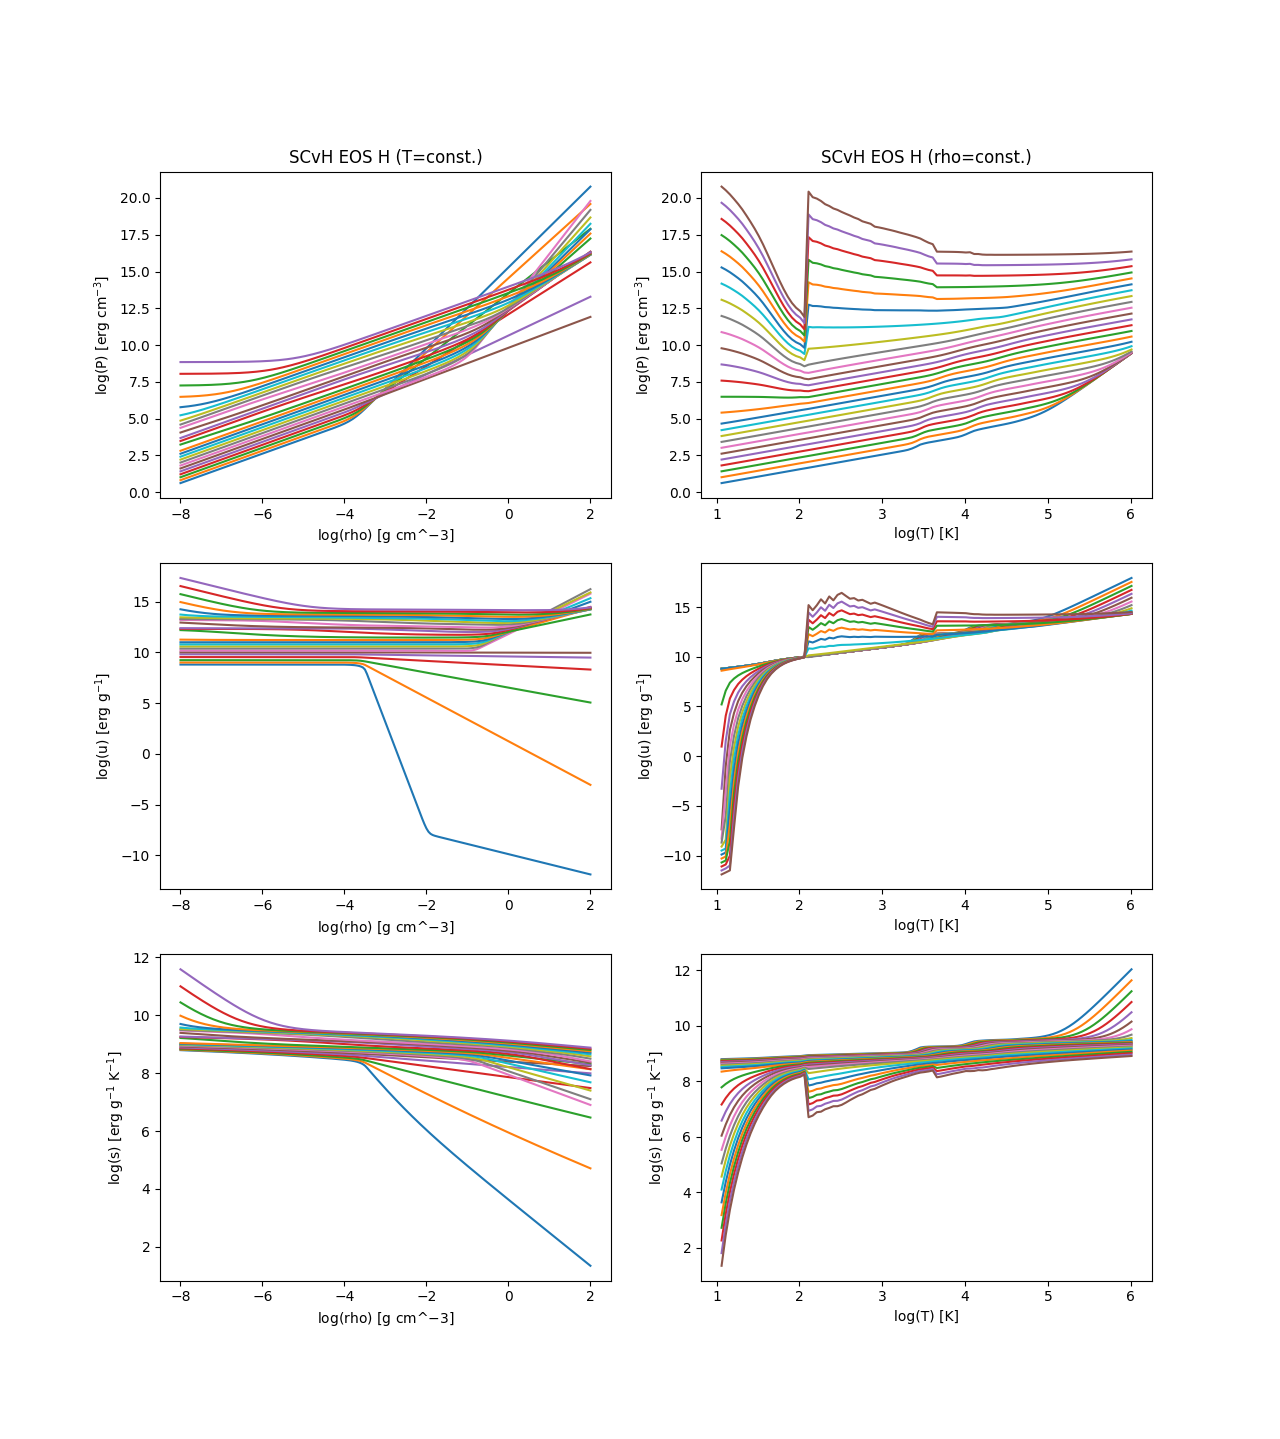

In [11]:
# Plot log(P), log(u) and log(s) of the original table
fig, ax = plt.subplots(3, 2)

x, y = fig.get_size_inches()

fig.set_size_inches(2*x, 3*y)

# P(rho, T=const)
for i in range(0, nT, nSkipT):
    ax[0][0].plot(logrho_table, logP[i,:], '-')
    
ax[0][0].set(xlabel="log(rho) [g cm^${-3}$]", ylabel="log(P) [erg cm$^{-3}$]")
ax[0][0].set(title="SCvH EOS H (T=const.)")

# P(rho=const, T)
for i in range(0, nRho, nSkipRho):
    ax[0][1].plot(logT_table, logP[:,i], '-')

ax[0][1].set(xlabel="log(T) [K]", ylabel="log(P) [erg cm$^{-3}$]")
ax[0][1].set(title="SCvH EOS H (rho=const.)")

# u(rho, T=const)
for i in range(0, nT, nSkipT):
    ax[1][0].plot(logrho_table, logu[i,:], '-')

ax[1][0].set(xlabel="log(rho) [g cm^${-3}$]", ylabel="log(u) [erg g$^{-1}$]")

# u(rho=const, T)
for i in range(0, nRho, nSkipRho):
    ax[1][1].plot(logT_table, logu[:,i], '-')

ax[1][1].set(xlabel="log(T) [K]", ylabel="log(u) [erg g$^{-1}$]")

# s(rho, T=const)
for i in range(0, nT, nSkipT):
    ax[2][0].plot(logrho_table, logs[i,:], '-')

ax[2][0].set(xlabel="log(rho) [g cm^${-3}$]", ylabel="log(s) [erg g$^{-1}$ K$^{-1}$]")

# s(rho=const, T)
for i in range(0, nRho, nSkipRho):
    ax[2][1].plot(logT_table, logs[:,i], '-')

ax[2][1].set(xlabel="log(T) [K]", ylabel="log(s) [erg g$^{-1}$ K$^{-1}$]")


In [12]:
# Limit the data to the region in which we are interested
logrho_grid_min = logrho_min
logrho_grid_max = -4.0

logT_grid_min = logT_min
logT_grid_max = 3.49

print("logrho_grid_min= {:} rho_grid_min= {:}".format(logrho_grid_min, 10**logrho_grid_min))
print("logrho_grid_max= {:} rho_grid_max= {:}".format(logrho_grid_max, 10**logrho_grid_max))
print("logT_grid_min= {:} T_grid_min= {:}".format(logT_grid_min, 10**logT_grid_min))
print("logT_grid_max= {:} T_grid_max= {:}".format(logT_grid_max, 10**logT_grid_max))
print()

index_logrho_grid = np.where(logrho_table < logrho_grid_max)[0]
index_logT_grid = np.where(logT_table < logT_grid_max)[0]

nRho_grid = np.size(index_logrho_grid)
nT_grid = np.size(index_logT_grid)
print("nRho= {:} nT= {:}".format(nRho_grid, nT_grid))

logrho_grid = logrho_table[index_logrho_grid]
logT_grid = logT_table[index_logT_grid]

logP_grid = logP[:nT_grid,:nRho_grid]
logu_grid = logu[:nT_grid,:nRho_grid]
logs_grid = logs[:nT_grid,:nRho_grid]

print(logP.shape)
print(logP_grid.shape)

logrho_grid_min= -8.0 rho_grid_min= 1e-08
logrho_grid_max= -4.0 rho_grid_max= 0.0001
logT_grid_min= 1.06 T_grid_min= 11.481536214968829
logT_grid_max= 3.49 T_grid_max= 3090.295432513592

nRho= 80 nT= 49
(100, 201)
(49, 80)


3.36


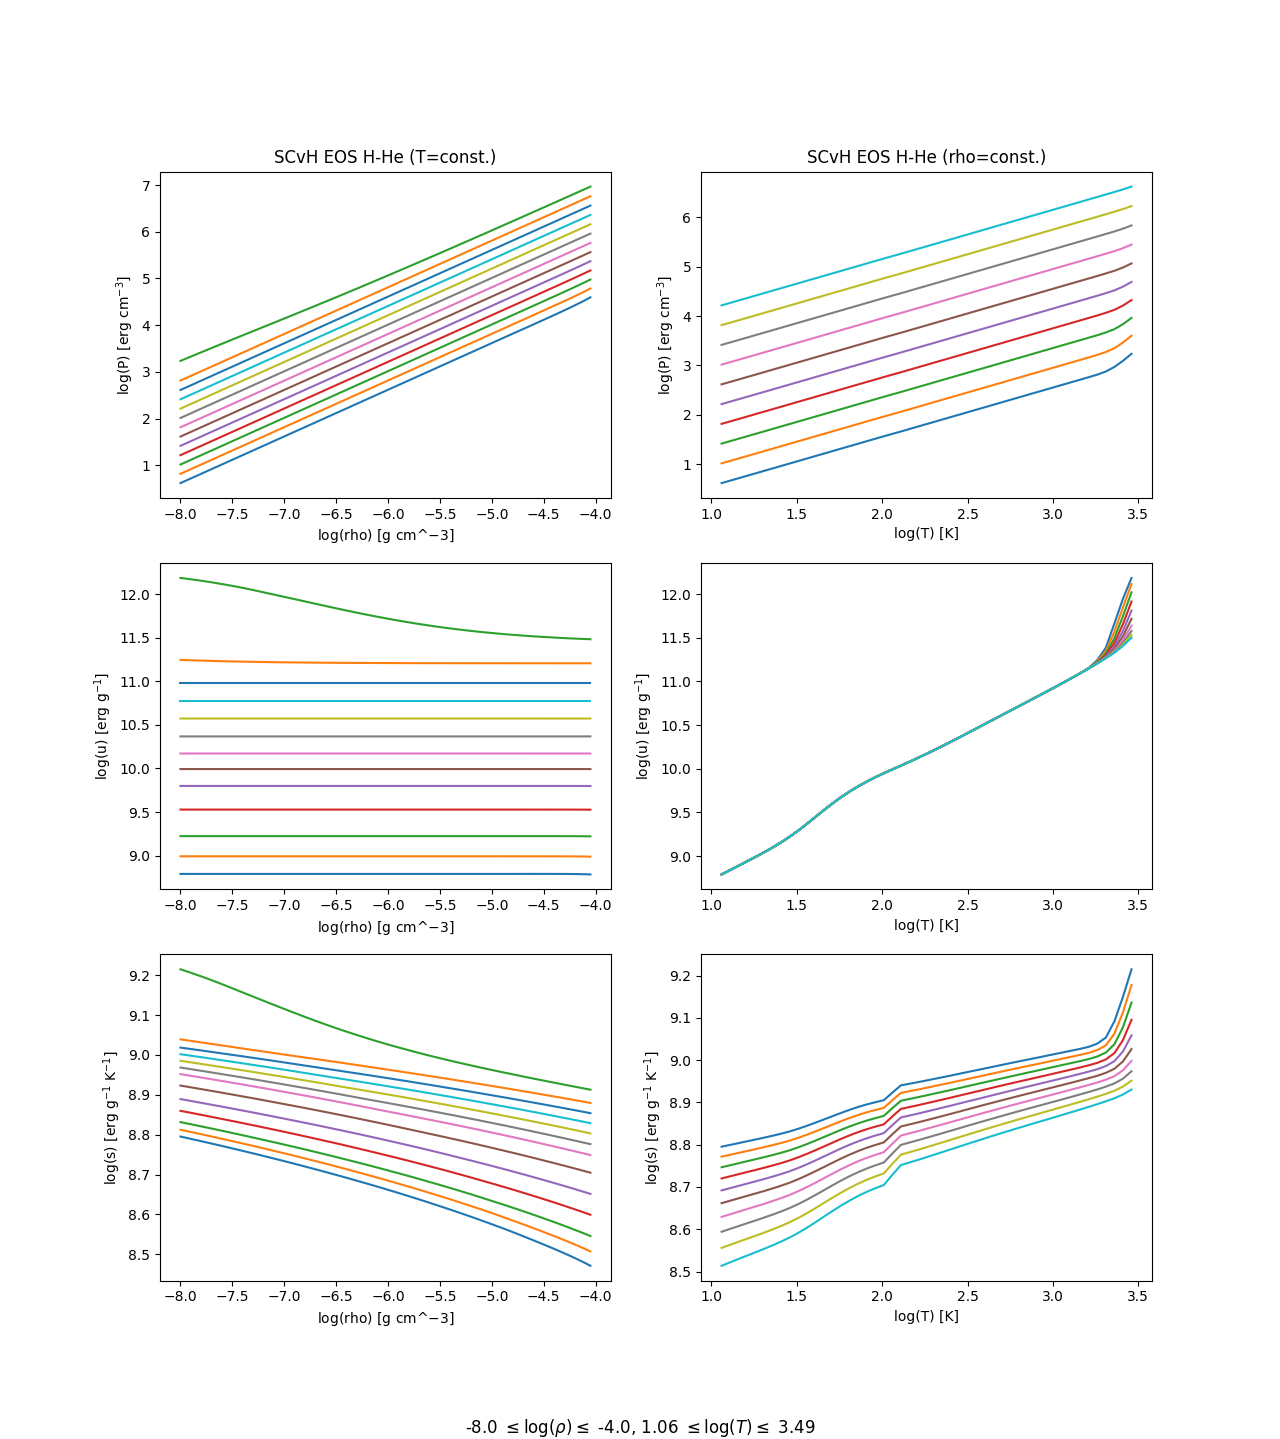

In [13]:
# Plot the reduced grid
fig, ax = plt.subplots(3, 2)

x, y = fig.get_size_inches()

fig.set_size_inches(2*x, 3*y)

fig.suptitle(r"{:} $\leq \log(\rho) \leq$ {:}, {:} $\leq \log(T) \leq$ {:}".format(logrho_grid_min, logrho_grid_max, logT_grid_min, logT_grid_max), x=0.5, y=0.0, verticalalignment='bottom', horizontalalignment='center')

# P(rho, T=const)
ax[0][0].set_prop_cycle(None)
for i in range(0, nT_grid, nSkipT):
    ax[0][0].plot(logrho_grid, logP_grid[i,:], '-')
    
ax[0][0].set(xlabel="log(rho) [g cm^${-3}$]", ylabel="log(P) [erg cm$^{-3}$]")
ax[0][0].set(title="SCvH EOS H-He (T=const.)")

# P(rho=const, T)
ax[0][1].set_prop_cycle(None)
for i in range(0, nRho_grid, nSkipRho):
    ax[0][1].plot(logT_grid, logP_grid[:,i], '-')

ax[0][1].set(xlabel="log(T) [K]", ylabel="log(P) [erg cm$^{-3}$]")
ax[0][1].set(title="SCvH EOS H-He (rho=const.)")

# u(rho, T=const)
ax[1][0].set_prop_cycle(None)
for i in range(0, nT_grid, nSkipT):
    ax[1][0].plot(logrho_grid, logu_grid[i,:], '-')
    
ax[1][0].set(xlabel="log(rho) [g cm^${-3}$]", ylabel="log(u) [erg g$^{-1}$]")

# u(rho=const, T)
ax[1][1].set_prop_cycle(None)
for i in range(0, nRho_grid, nSkipRho):
    ax[1][1].plot(logT_grid, logu_grid[:,i], '-')

ax[1][1].set(xlabel="log(T) [K]", ylabel="log(u) [erg g$^{-1}$]")

# s(rho, T=const)
ax[2][0].set_prop_cycle(None)
for i in range(0, nT_grid, nSkipT):
    ax[2][0].plot(logrho_grid, logs_grid[i,:], '-')
    
ax[2][0].set(xlabel="log(rho) [g cm^${-3}$]", ylabel="log(s) [erg g$^{-1}$ K$^{-1}$]")

# s(rho=const, T)
ax[2][1].set_prop_cycle(None)
for i in range(0, nRho_grid, nSkipRho):
    ax[2][1].plot(logT_grid, logs_grid[:,i], '-')

ax[2][1].set(xlabel="log(T) [K]", ylabel="log(s) [erg g$^{-1}$ K$^{-1}$]")


print(logT_grid[-3])

(8.620671309, 12.353908091)

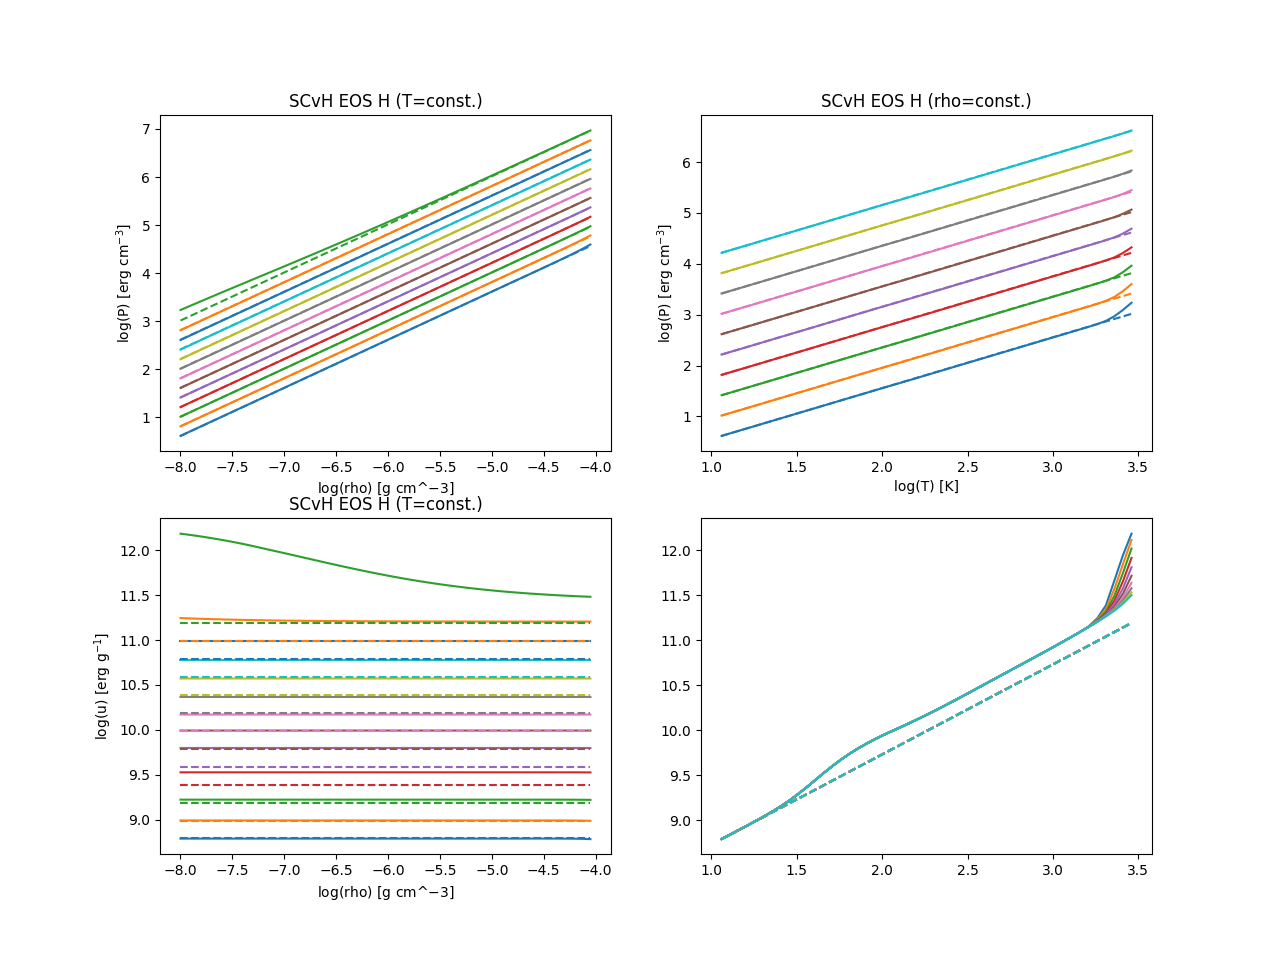

In [14]:
# Compare the reduced grid to an ideal gas
fig, ax = plt.subplots(2, 2)

x, y = fig.get_size_inches()

fig.set_size_inches(2*x, 2*y)

# P(rho, T=const)
ax[0][0].set_prop_cycle(None)
for i in range(0, nT_grid, nSkipT):
    ax[0][0].plot(logrho_grid, logP_grid[i,:], '-')

ax[0][0].set_prop_cycle(None)
for i in range(0, nT_grid, nSkipT):
    ax[0][0].plot(logrho_grid, np.log10(press_ideal_gas(10**logrho_grid, 10**logT_grid[i])), '--')

ax[0][0].set(xlabel="log(rho) [g cm^${-3}$]", ylabel="log(P) [erg cm$^{-3}$]")
ax[0][0].set(title="SCvH EOS H (T=const.)")

# P(rho=const, T)
ax[0][1].set_prop_cycle(None)
for i in range(0, nRho_grid, nSkipRho):
    ax[0][1].plot(logT_grid, logP_grid[:,i], '-')

ax[0][1].set_prop_cycle(None)
for i in range(0, nRho_grid, nSkipRho):
    ax[0][1].plot(logT_grid, np.log10(press_ideal_gas(10**logrho_grid[i], 10**logT_grid)), '--')

    
ax[0][1].set(xlabel="log(T) [K]", ylabel="log(P) [erg cm$^{-3}$]")
ax[0][1].set(title="SCvH EOS H (rho=const.)")

# u(rho, T=const)
ax[1][0].set_prop_cycle(None)
for i in range(0, nT_grid, nSkipT):
    ax[1][0].plot(logrho_grid, logu_grid[i,:], '-')

ax[1][0].set_prop_cycle(None)
for i in range(0, nT_grid, nSkipT):
    ax[1][0].plot(logrho_grid, np.ones(nRho_grid)*np.log10(intenergy_ideal_gas(10**logT_grid[i])), '--')

ax[1][0].set(xlabel="log(rho) [g cm^${-3}$]", ylabel="log(u) [erg g$^{-1}$]")
ax[1][0].set(title="SCvH EOS H (T=const.)")


# u(rho=const, T)
ax[1][1].set_prop_cycle(None)
for i in range(0, nRho_grid, nSkipRho):
    ax[1][1].plot(logT_grid, logu_grid[:,i], '-')

ax[1][1].set_prop_cycle(None)
for i in range(0, nRho_grid, nSkipRho):
    ax[1][1].plot(logT_grid, np.log10(intenergy_ideal_gas(10**logT_grid)), '--')

ax[1][1].get_xlim()
ax[1][1].get_ylim()


In [15]:
# Write the restricted EOS table to an output file.
write_eos_table("scvh_hhe_y0.275_dt_cgs_lowrhot.csv", logrho_grid, logT_grid, logP_grid, logu_grid, logs_grid)
write_eos_table("scvh_hhe_y0.275_dt_cgs_lowrhot.txt", logrho_grid, logT_grid, logP_grid, logu_grid, logs_grid, delimiter=" ")


new_table = np.loadtxt("scvh_hhe_y0.275_dt_cgs_lowrhot.csv", delimiter=",")

logT_new   = new_table[:, 0] 
logrho_new = new_table[:, 1]
logP_new   = new_table[:, 2]
logu_new   = new_table[:, 3]
logs_new   = new_table[:, 4]

# The restricted SCVH EOS table has a different size
nRho_new = np.size(logrho_grid)
nT_new   = np.size(logT_grid)

print("nRho_grid = {:}".format(nRho_grid))
print("nT_grid   = {:}".format(nT_grid))

logrho_new = logrho_new[0:nRho_new]
logT_new = logT_new[0:np.size(logT_new):nRho_new]

# Split into arrays of constant T
logP_array_new = np.split(logP_new, nT_new)
logu_array_new = np.split(logu_new, nT_new)
logs_array_new = np.split(logs_new, nT_new)

# Generate 2d arrays
logP_new = np.vstack(logP_array_new)
logu_new = np.vstack(logu_array_new)
logs_new = np.vstack(logs_array_new)

print(np.where(np.abs(logrho_new-logrho_grid) > 0.0))
print(np.where(np.abs(logT_new-logT_grid) > 0.0))
print(np.where(np.abs(logP_new-logP_grid) > 0.0))
print(np.where(np.abs(logs_new-logs_grid) > 0.0))
print(np.where(np.abs(logs_new-logs_grid) > 0.0))


nRho_grid = 80
nT_grid   = 49
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


In [ ]:
# Check how the table extrapolates to rho = 0
logrho_min_extrap = -25.0
logrho_max_extrap = 1.0

# Generate interpolation functions for all isotherms
logP_int = list()

for i in range(0, nT_table_grid):
    logP_int.append(interp.interp1d(logrho_grid, logP_grid[i,:], kind='linear')

# Generate interpolation axis
logrho_int = np.linspace(-8.0, -4.0)
